In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#import the dataset
df = pd.read_csv('../data/clean_SSTEMP_sensor.csv')

In [3]:
# preprocess the time column
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df.sort_index(inplace=True)

# Extract the hour from the 'Time' index
df['Hour'] = df.index.hour

# Create cyclical features using sine and cosine for 'Hour'
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Optionally, drop the 'Hour' column if it's no longer needed
df.drop(columns=['Hour'], inplace=True)

# Check the resulting dataframe
print(df.head())

                     State         Device Unit  Hour_sin  Hour_cos
Time                                                              
2024-09-12 01:04:03   13.0  SSTEMP_sensor    C  0.258819  0.965926
2024-09-12 01:04:28   12.9  SSTEMP_sensor    C  0.258819  0.965926
2024-09-12 01:04:53   12.9  SSTEMP_sensor    C  0.258819  0.965926
2024-09-12 01:05:18   12.9  SSTEMP_sensor    C  0.258819  0.965926
2024-09-12 01:05:43   12.9  SSTEMP_sensor    C  0.258819  0.965926


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6216 entries, 2024-09-12 01:04:03 to 2024-09-13 21:14:41
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     6216 non-null   float64
 1   Device    6216 non-null   object 
 2   Unit      6216 non-null   object 
 3   Hour_sin  6216 non-null   float64
 4   Hour_cos  6216 non-null   float64
dtypes: float64(3), object(2)
memory usage: 291.4+ KB


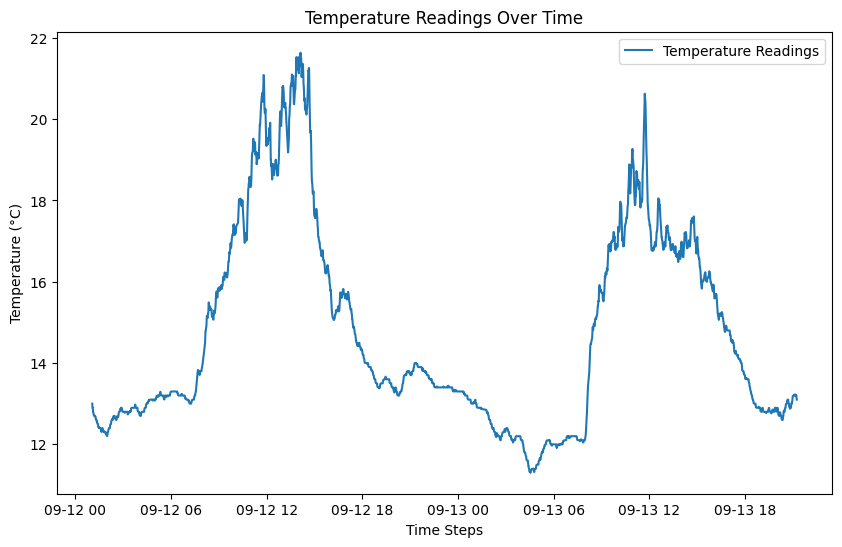

In [5]:
#visualize dataset
plt.figure(figsize=(10, 6))
plt.plot(df['State'], label='Temperature Readings')
plt.title('Temperature Readings Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [6]:
#scale readings
scaler = MinMaxScaler()
df['State'] = scaler.fit_transform(df[['State']])

In [7]:
def create_sequences(data, input_steps=10, output_steps=48):
    X, y = [], []
    
    for i in range(len(data) - input_steps - output_steps + 1):
        # Include both the 'State', 'Hour_sin', and 'Hour_cos' in the input
        X.append(data[['State', 'Hour_sin', 'Hour_cos']].iloc[i:i+input_steps].values)
        y.append(data['State'].iloc[i+input_steps:i+input_steps+output_steps].values)
        
    return np.array(X), np.array(y)

# Example usage with your DataFrame:
X, y = create_sequences(df)

In [8]:
# split into train/test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
# Reshape input for LSTM: (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))  # 3 features: 'State', 'Hour_sin', 'Hour_cos'
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))

In [10]:
# Build the LSTM model
model = Sequential()

# Define the input layer explicitly
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# First LSTM layer with dropout
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))

# Dense output layer (predicting 48 future time steps)
model.add(Dense(48))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 256)             │         135,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │           3,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,464 (861.19 KB)

 Trainable params: 220,464 (861.19 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0574 - val_loss: 0.0087
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0070
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0063
Epoch 8/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 0.0060
Epoch 9/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 10/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 0.0066
Epoch 11/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0070
Epoch 12/100
139/139 ━━━━━━━━━━━━━━━━━━

In [12]:
# Predict on the test set
y_pred = model.predict(X_test)

# Since we scaled the data, we need to inverse transform to get the original values
# Reshape y_test and y_pred to 2D arrays for inverse transformation
y_test_flat = y_test.reshape(-1, 1)
y_pred_flat = y_pred.reshape(-1, 1)

# Inverse transform
y_test_inverse = scaler.inverse_transform(y_test_flat)
y_pred_inverse = scaler.inverse_transform(y_pred_flat)

# Reshape back to original shape
y_test_inverse = y_test_inverse.reshape(y_test.shape)
y_pred_inverse = y_pred_inverse.reshape(y_pred.shape)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [13]:
def calculate_metrics(y_true, y_pred):
    # Flatten the arrays for metric calculation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)
    
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(F"R2: {r2}")

calculate_metrics(y_test_inverse, y_pred_inverse)

MAE: 0.384522631231137
MSE: 0.22891392235952088
R2: 0.9249253867578235


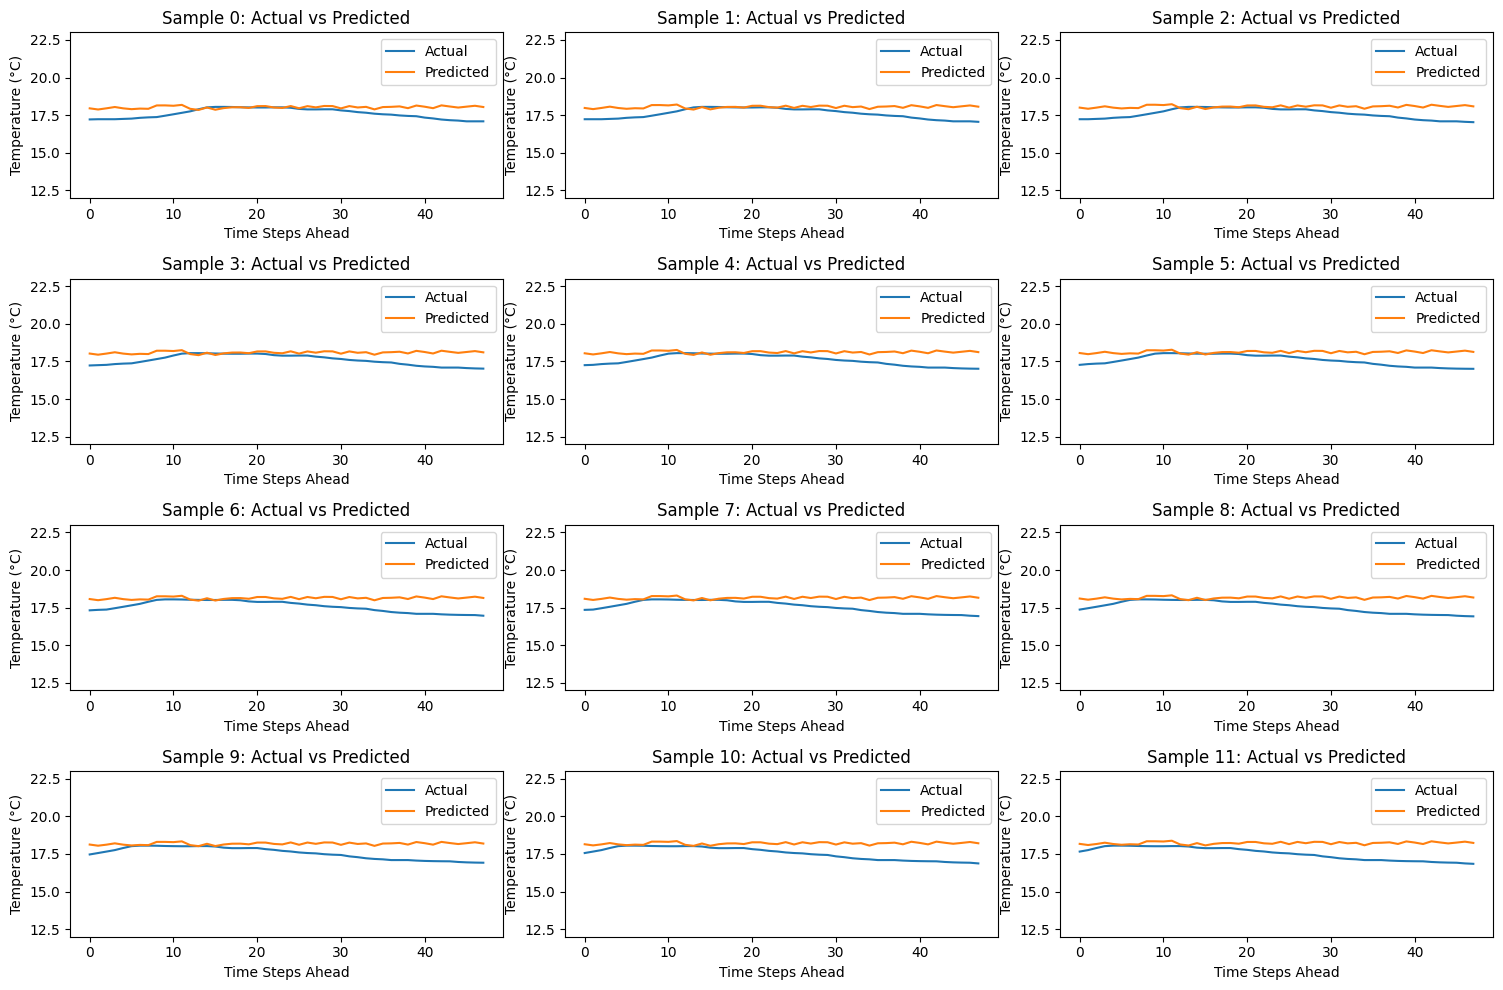

In [14]:
# Define the number of rows and columns for the subplots
rows, cols = 4, 3  # 4 rows, 3 columns = 12 subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each subplot and plot the actual vs predicted values
for i in range(12):  # 12 plots
    sample_index = i + 27  # Adjust index as needed
    axes[i].plot(y_test_inverse[sample_index], label='Actual')
    axes[i].plot(y_pred_inverse[sample_index], label='Predicted')
    axes[i].set_xlabel('Time Steps Ahead')
    axes[i].set_ylabel('Temperature (°C)')
    axes[i].set_ylim(12, 23)
    axes[i].set_title(f'Sample {i}: Actual vs Predicted')
    axes[i].legend()

# Adjust layout to avoid overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

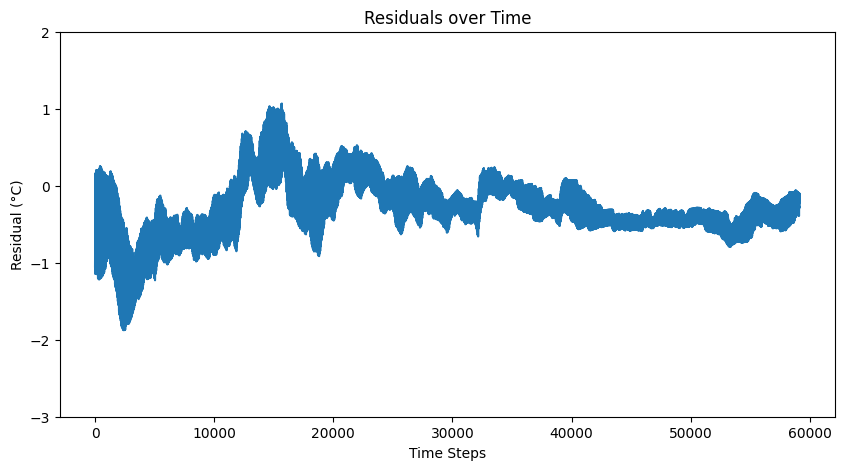

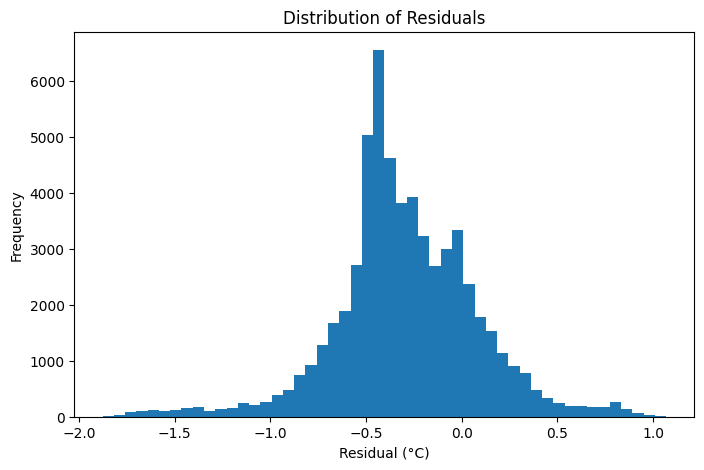

In [17]:
residuals = y_test_inverse - y_pred_inverse

# Plot residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals.flatten())
plt.xlabel('Time Steps')
plt.ylabel('Residual (°C)')
plt.title('Residuals over Time')
plt.ylim(-3, 2)
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals.flatten(), bins=50)
plt.xlabel('Residual (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()